In [156]:
import random  # Functions related to random number generation
import numpy as np  # Numerical library for mathematical operations
import os  # Functions related to the operating system
import pandas as pd  # Library for data manipulation and analysis of tabular data
import time  # To calculate the runtime

# Neural networks and model
from sklearn.model_selection import train_test_split  # Split dataset into training and testing sets
import tensorflow as tf
import tensorflow.keras.layers as layers # Layers for building neural networks
from tensorflow.keras.models import Sequential # Linear stack of layers

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt  # Plotting library for creating diagrams
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import subplots
from sklearn.metrics import confusion_matrix
from plotly.offline import plot, iplot
from sklearn.metrics import classification_report
import matplotlib.image as mpimg

SEED=7
os.environ['PYTHONHASHEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC']='1'
os.environ['PYTHONHASHEED']='1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [224]:
#We take the data from the file that we have in the same folder 
df = pd.read_csv("dataset.csv")
df.head()

,ID,PATH,TYPE
0,1,DATASET/L/L-1,LENSE
1,2,DATASET/L/L-2,LENSE
2,3,DATASET/L/L-3,LENSE
3,4,DATASET/L/L-4,LENSE
4,5,DATASET/L/L-5,LENSE


In [225]:
df.shape

(8118, 3)

In [226]:
# Obtenemos las estadisticas descriptivas del dataset donde vemos:
# Numero de valores no nulos, media aritmetica de los valores, desviacion estandar, valor minimo, cuartiles y valor maximo
df.describe()

,ID
count,8118.000000
mean,4059.500000
std,2343.609076
min,1.000000
25%,2030.250000
50%,4059.500000
75%,6088.750000
max,8118.000000


In [227]:
#Comprobamos si hay algun valor nulo
df.isnull().sum()

ID      0
PATH    0
TYPE    0
dtype: int64

In [228]:
df.head() # Data from the start of the dataset

,ID,PATH,TYPE
0,1,DATASET/L/L-1,LENSE
1,2,DATASET/L/L-2,LENSE
2,3,DATASET/L/L-3,LENSE
3,4,DATASET/L/L-4,LENSE
4,5,DATASET/L/L-5,LENSE


In [229]:
df.tail()# Data from the end of the dataset

,ID,PATH,TYPE
8113,8114,DATASET/G/G-7451,GALAXY
8114,8115,DATASET/G/G-7452,GALAXY
8115,8116,DATASET/G/G-7453,GALAXY
8116,8117,DATASET/G/G-7454,GALAXY
8117,8118,DATASET/G/G-7455,GALAXY


In [231]:

# We adjust the dataset to balance the number of data we handle
# We show the number of data of the different types
print("Distribution before balancing:")
print(df['TYPE'].value_counts())

# Set a limit for the number of elements of type 'GALAXY'
galaxy_limit = 300 
# Check if there are enough elements of type 'GALAXY'
count_galaxy = df[df['TYPE'] == 'GALAXY'].shape[0]

if count_galaxy > galaxy_limit:
    # Sampling
    df_galaxy = df[df['TYPE'] == 'GALAXY'].sample(n=galaxy_limit, random_state=42)
    df_no_galaxy = df[df['TYPE'] != 'GALAXY']
    df_balanced = pd.concat([df_no_galaxy, df_galaxy])
    print("Distribution AFTER balancing:")
    print(df_balanced['TYPE'].value_counts())

    df_balanced.to_csv("dataset_balanced.csv", index=False)
    df2 = df_balanced 
else:
    print("Not enough elements with TYPE == 'GALAXY' to meet the limit.")


Distribution before balancing:
TYPE
GALAXY     7455
NEBULA      279
CLUSTER     197
LENSE       187
Name: count, dtype: int64
Distribution AFTER balancing:
TYPE
GALAXY     300
NEBULA     279
CLUSTER    197
LENSE      187
Name: count, dtype: int64


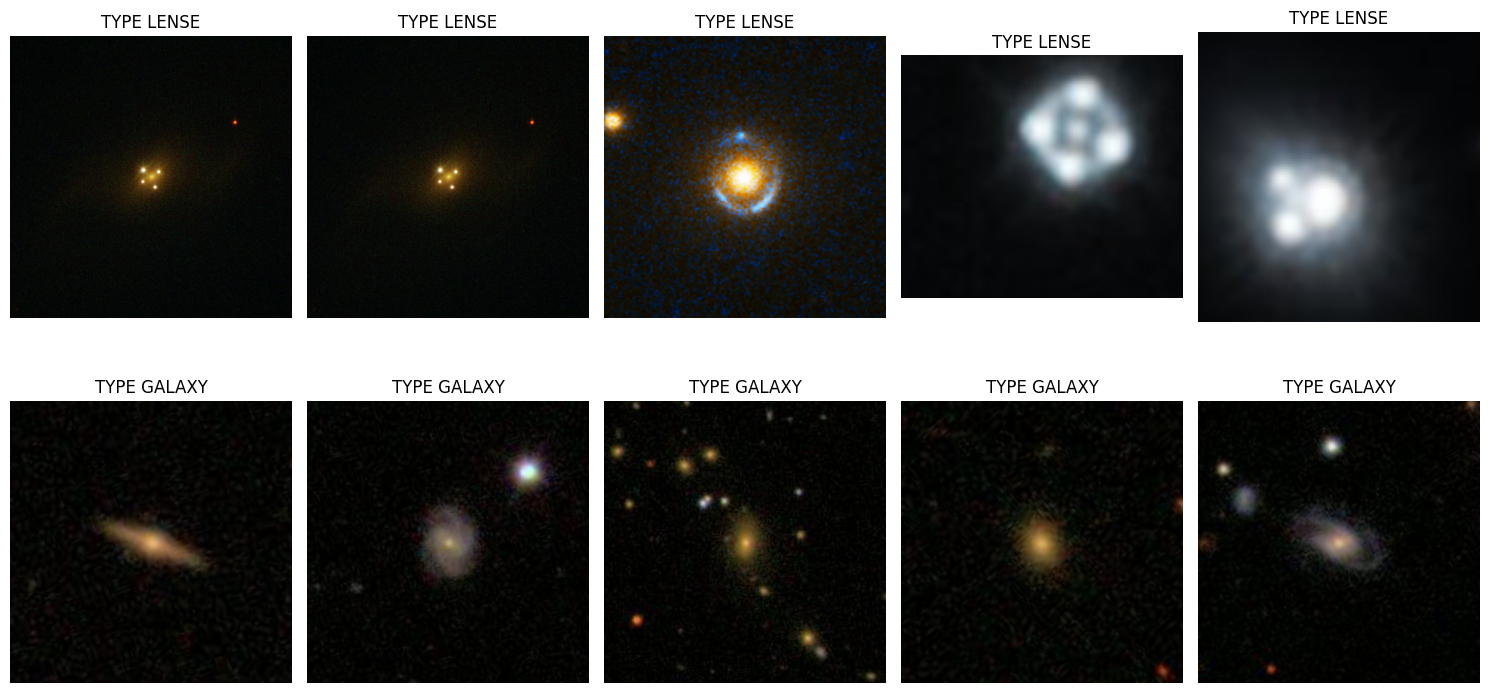

In [233]:

# The template for placing the images is created
fig, axs = plt.subplots(2, 5, figsize=(15, 8))  # Adjust the size of each figure

# Loops through the DataFrame and displays the images in the subgraphs
for index, row in df2.iterrows():
    img_path = row['PATH'] + ".jpg"  # Because the routes in the dataset come without the extension
    img = mpimg.imread(img_path)

    # Calculates the appropriate index for the axle arrangement
    row_index = index // 5
    col_index = index % 5

    # The image is displayed
    ax = axs[row_index if row_index <= 1 else -1, col_index]
    ax.imshow(img, cmap="gray")  # cmap="gray" for grayscale images
    ax.axis('off')
    ax.set_title(f'TYPE {row["TYPE"]}') # We assign the title for each type

fig.tight_layout()
plt.show()

In [234]:
len(df2)

963

In [ ]:
print(df2["TYPE"].value_counts())

In [237]:
from sklearn.preprocessing import LabelEncoder  # Encode labels 

# Assign numeric values to classes and make them integers
label_encoder = LabelEncoder()
df2["TYPE"] = label_encoder.fit_transform(df2["TYPE"])

##split the dataset to a training and test set
#training data should be 80% of the whole dataset, rest is for testing
train_df, test_df = train_test_split(df2, test_size=0.3, random_state=SEED)

# Restore original class names
df2["TYPE"] = label_encoder.inverse_transform(df2["TYPE"])
train_df["TYPE"] = label_encoder.inverse_transform(train_df["TYPE"])
test_df["TYPE"] = label_encoder.inverse_transform(test_df["TYPE"])

print("Total rows on df2:", df2.shape[0]) #total data
print("Total rows on train_df:", train_df.shape[0]) # train data
print("Total rows on test_df:", test_df.shape[0]) # test data

# preprocessing function, with each dataset (train and test), numbers of classes
# brief: processing the dataset to split image and label and adjust the image
# about: receives the training and test sets separately and through the TYPE column we obtain the label
# We resized the image for better processing to 50x50
def data_preprocessing(df, num_classes, num_samples=None):
    if num_samples:
        df = df.head(num_samples)

    # numeric values
    label_encoder = LabelEncoder()
    df["TYPE"] = label_encoder.fit_transform(df["TYPE"])

    y = tf.keras.utils.to_categorical(df["TYPE"], num_classes)
    x = []

    for index, row in df.iterrows():
        img_path = row['PATH'] + ".jpg"  
        # We convert the image to grayscale and it is resized -> suitable for machine learning
        img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=(100, 100))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array /= 255.0  # Normalize pixel values to range [0, 1]
        x.append(img_array)

    x = tf.convert_to_tensor(x) 
    return x, y


train_size = 568  #Desired training set size.
# NUMBER CLASSES 1O ? NOT WORKING WITH 4
X_train, y_train = data_preprocessing(train_df,4, num_samples=train_size) 
X_test, y_test = data_preprocessing(test_df,4)

print("X_train size:", X_train.shape)
print("y_train size:", y_train.shape)
print("X_test size:", X_test.shape)
print("y_test size:", y_test.shape)


Total rows on df2: 963
Total rows on train_df: 674
Total rows on test_df: 289
X_train size: (568, 100, 100, 1)
y_train size: (568, 4)
X_test size: (289, 100, 100, 1)
y_test size: (289, 4)


In [238]:
print("lONG", len(X_train), len(X_test))
print("lONG", len(y_train), len(y_test))

lONG 568 289
lONG 568 289


In [239]:
y_train[0]

array([0., 1., 0., 0.], dtype=float32)

In [240]:
len(X_train)

568

In [241]:
model = tf.keras.Sequential(name="Astro_cnn") # NEW MODEL

# First layer: convolution layer with:
#16 filters: Three-dimensional arrays that go through the image to perform the convolution operation
# 5x5 kernel: Size of the matrix used in the convolution
# with a ReLU activation
# stride of 2: Number of pixels that the kernel moves horizontally in the image
# padding="same": Necessary infill is added to the entrance to maintain the same height and width as at the entrance
# and input form (28,28,1): Size of the images with which the model will work
model.add(layers.Conv2D(filters=16, kernel_size=(5,5), activation="relu",
                        strides=2, padding="same", 
                        input_shape=(100,100,1)))

# Second layer: pooling layer (MaxPool) with:
# tamaño de pool de 2x2: Tamaño de la ventana sobre la que se va a reducir las dimensiones 
#                        espaciales de la representacion anterior
# stride=None and padding="same"
model.add(layers.MaxPool2D(pool_size=(2,2), strides=None, padding="same"))

# # Third and fourth: Convolution layers with 32 filters, 3x3 kernel, ReLU activation, stride of 1 and "valid" padding
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", 
                       strides=1, padding="valid"))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", 
                        strides=1, padding="same"))

model.add(layers.MaxPool2D(pool_size=(2,2),strides=None, padding="valid"))
# Layer that converts the output of the previous layer into a single dimension.
model.add(layers.Flatten())
model.add(layers.Dropout(.2)) # Dropout layer for regularization
model.add(layers.Dense(128, activation="relu"))# layer with 128 neurons
model.add(layers.Dropout(.2))
# Output layer 
model.add(layers.Dense(4, activation="softmax")) # Many units as classes we havet

model.summary()

Model: "Astro_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 50, 50, 16)        416       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 25, 25, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 23, 23, 32)        4640      
                                                                 
 conv2d_47 (Conv2D)          (None, 23, 23, 32)        9248      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 11, 11, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 3872)              0 

In [242]:
epochs=80

start_time = time.time()  # Start of the runtime 
print(f"Starting training: {start_time}")

# Compilation of the model with the adam optimizer
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs)
    
end_time = time.time()  # Get runtime in seconds
print(f"End of training: {end_time}")
elapsed_time = end_time - start_time  #Calculate the time difference
print("Training time: ",elapsed_time/60, "minutes")

Starting training: 1705313715.4200504
Epoch 1/80
18/18 [==============================] - 1s 20ms/step - loss: 1.1217 - accuracy: 0.5246 - val_loss: 0.9210 - val_accuracy: 0.5744
Epoch 2/80
18/18 [==============================] - 0s 13ms/step - loss: 0.8221 - accuracy: 0.6602 - val_loss: 0.7794 - val_accuracy: 0.6574
Epoch 3/80
18/18 [==============================] - 0s 12ms/step - loss: 0.7110 - accuracy: 0.7042 - val_loss: 0.6592 - val_accuracy: 0.7578
Epoch 4/80
18/18 [==============================] - 0s 12ms/step - loss: 0.6221 - accuracy: 0.7430 - val_loss: 0.6814 - val_accuracy: 0.7301
Epoch 5/80
18/18 [==============================] - 0s 12ms/step - loss: 0.5852 - accuracy: 0.7606 - val_loss: 0.6768 - val_accuracy: 0.7785
Epoch 6/80
18/18 [==============================] - 0s 12ms/step - loss: 0.5230 - accuracy: 0.8046 - val_loss: 0.5981 - val_accuracy: 0.7785
Epoch 7/80
18/18 [==============================] - 0s 11ms/step - loss: 0.4575 - accuracy: 0.8380 - val_loss: 0.590

18/18 [==============================] - 0s 14ms/step - loss: 0.0151 - accuracy: 0.9965 - val_loss: 1.0930 - val_accuracy: 0.8201
Epoch 59/80
18/18 [==============================] - 0s 13ms/step - loss: 0.0089 - accuracy: 0.9965 - val_loss: 1.0497 - val_accuracy: 0.8547
Epoch 60/80
18/18 [==============================] - 0s 12ms/step - loss: 0.0084 - accuracy: 0.9982 - val_loss: 1.1061 - val_accuracy: 0.8235
Epoch 61/80
18/18 [==============================] - 0s 12ms/step - loss: 0.0084 - accuracy: 0.9982 - val_loss: 1.1680 - val_accuracy: 0.8408
Epoch 62/80
18/18 [==============================] - 0s 11ms/step - loss: 0.0179 - accuracy: 0.9947 - val_loss: 1.1468 - val_accuracy: 0.8339
Epoch 63/80
18/18 [==============================] - 0s 14ms/step - loss: 0.0263 - accuracy: 0.9947 - val_loss: 1.0664 - val_accuracy: 0.8339
Epoch 64/80
18/18 [==============================] - 0s 13ms/step - loss: 0.0178 - accuracy: 0.9947 - val_loss: 1.1311 - val_accuracy: 0.8166
Epoch 65/80
18/18 

Text(0.5, 0, 'Epoch')

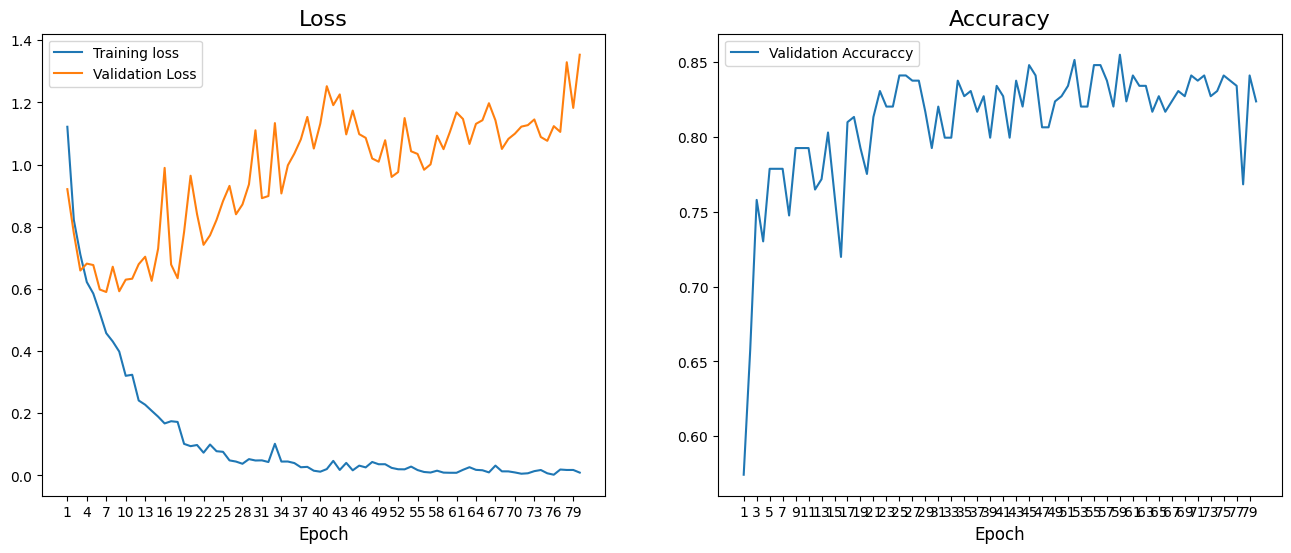

In [243]:
#We show the loss and accuracy metrics during training in different epochs
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize=16
axis_fontsize=12

ax1.plot(range(1, epochs+1), history.history['loss'], label='Training loss')
ax1.plot(range(1,epochs+1), history.history["val_loss"], label="Validation Loss")
ax1.legend()
ax1.set_xticks(range(1,epochs+1,3))
ax1.set_title("Loss", fontsize=title_fontsize)
ax1.set_xlabel("Epoch", fontsize=axis_fontsize)

ax2.plot(range(1,epochs+1), history.history["val_accuracy"], label="Validation Accuraccy")
ax2.legend()
ax2.set_xticks(range(1,epochs+1,2))
ax2.set_title("Accuracy", fontsize=title_fontsize)
ax2.set_xlabel("Epoch", fontsize=axis_fontsize)

In [244]:
#We show the loss and accuracy metrics during training in different epochs but diferent approach 
# When we change the percentage of data in the training set and increase it to the test set,
# we can see a slight difference in the graphs, increasing the validation accuracy and validation loss
def create_trace(x,y, ylabel, color):
    trace = go.Scatter(x = x,y = y,
                      name=ylabel, 
                      marker = dict(color=color),
                      mode="markers+lines",
                      text=x)
    return trace
def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss= history.history['val_loss']
    
    epochs = list(range(1,len(acc)+1))
    trace_ta = create_trace(epochs,acc, "Training accuracy", "Blue")
    trace_va = create_trace(epochs,val_acc, "Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss, "Training loss", "Cyan")
    trace_vl = create_trace(epochs,val_loss, "Validation loss", "Magenta")
    
    fig = subplots.make_subplots(
        rows=1, cols=2, subplot_titles=('Training and validation accuracy', 'Validation loss'))
    fig.append_trace(trace_ta, 1, 1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title='Epoch')
    fig['layout']['xaxis2'].update(title='Epoch')
    fig['layout']['yaxis'].update(title='Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title='Loss', range=[0,1])
        
    iplot(fig, filename='Interactive accuracy and loss')
plot_accuracy_and_loss(history)


In [245]:
y_pred = model.predict(X_test) # We get the predicted data and its labels
y_test_labels=np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

10/10 [==============================] - 0s 3ms/step


In [246]:
print(len(y_pred))

print(len(X_test))

print(y_pred_labels)

289
289
[0 3 1 1 0 3 0 1 3 0 1 3 1 3 1 3 0 3 3 1 3 3 1 2 1 1 3 0 0 2 2 2 1 1 3 2 3
 3 3 3 2 1 1 2 3 1 1 2 3 1 3 3 2 1 1 1 0 3 1 3 2 0 0 1 1 3 1 3 3 3 2 0 3 3
 1 2 1 3 0 1 1 3 1 3 3 1 3 3 0 2 3 1 1 3 3 2 3 0 1 0 1 3 0 1 3 1 0 1 1 2 3
 1 1 3 0 3 1 0 1 2 0 3 1 3 3 0 3 1 1 3 3 2 0 1 3 0 3 1 2 1 3 3 3 1 0 0 1 3
 2 3 1 0 1 3 3 1 2 0 1 3 2 1 3 3 0 0 3 3 1 3 0 2 2 0 2 2 1 0 0 1 2 2 3 3 3
 3 3 0 1 0 1 3 2 3 3 0 2 0 1 1 0 1 3 3 0 0 3 1 2 1 3 1 3 1 1 0 1 0 0 1 3 2
 3 1 0 1 0 3 0 2 3 0 3 3 3 2 0 3 1 1 3 3 1 2 0 3 1 3 0 1 1 0 2 1 2 3 3 3 0
 1 1 1 2 1 3 3 1 3 2 3 0 0 3 3 2 1 1 1 1 3 0 1 1 3 3 1 0 0 2]


In [247]:
y_test_labels = np.argmax(y_test, axis=1) # The data needs to be transformed
y_pred_labels = np.argmax(y_pred, axis=1)

In [249]:
unique_labels = np.unique(df2["TYPE"])
y_test_labels_str = label_encoder.inverse_transform(y_test_labels)
y_pred_labels_str = label_encoder.inverse_transform(y_pred_labels)

# The confusion matrix is obtained without normalization
conf_mat = confusion_matrix(y_test_labels_str, y_pred_labels_str, labels=unique_labels, normalize='true') * 100
#New dataframe for the confusion matrix 
df3 = pd.DataFrame(conf_mat, columns=[f'{label}_pred' for label in unique_labels], index=[f'{label}_true' for label in unique_labels])

# Mostrar el DataFrame
print(df3)

              CLUSTER_pred  GALAXY_pred  LENSE_pred  NEBULA_pred
CLUSTER_true     80.392157     0.000000    5.882353    13.725490
GALAXY_true       0.000000    93.684211    3.157895     3.157895
LENSE_true       10.909091     3.636364   58.181818    27.272727
NEBULA_true      11.363636     0.000000    2.272727    86.363636


<Axes: >

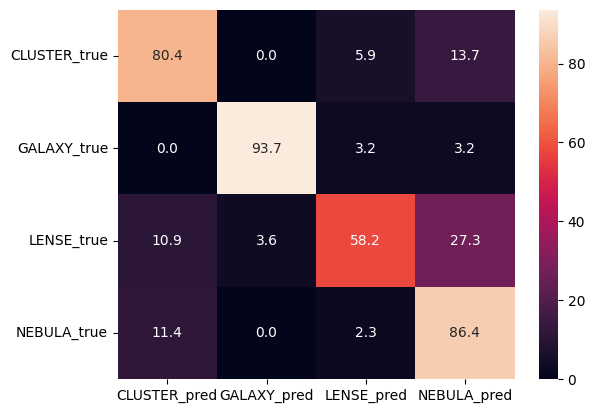

In [250]:
sns.heatmap(df3, annot=True, fmt=".1f")

In [251]:
from sklearn.metrics import classification_report

y_test_labels_str = label_encoder.inverse_transform(y_test_labels)
y_pred_labels_str = label_encoder.inverse_transform(y_pred_labels)

target_names = [f"Class {label} :" for label in unique_labels]

# the classification report is printed
print(classification_report(y_test_labels_str, y_pred_labels_str, labels=unique_labels, target_names=target_names))


                 precision    recall  f1-score   support

Class CLUSTER :       0.72      0.80      0.76        51
 Class GALAXY :       0.98      0.94      0.96        95
  Class LENSE :       0.80      0.58      0.67        55
 Class NEBULA :       0.75      0.86      0.80        88

       accuracy                           0.82       289
      macro avg       0.81      0.80      0.80       289
   weighted avg       0.83      0.82      0.82       289



In [252]:
#Saving the model
model.save('ASTRODETECTOR.h5')
model.save('ASTRODETECTOR.model')

C:\Users\Alberto\anaconda3\envs\HOLA\lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: ASTRODETECTOR.model\assets


INFO:tensorflow:Assets written to: ASTRODETECTOR.model\assets


DATASET/L/L-1
Main path: DATASET/
['C', 'G', 'L', 'N']


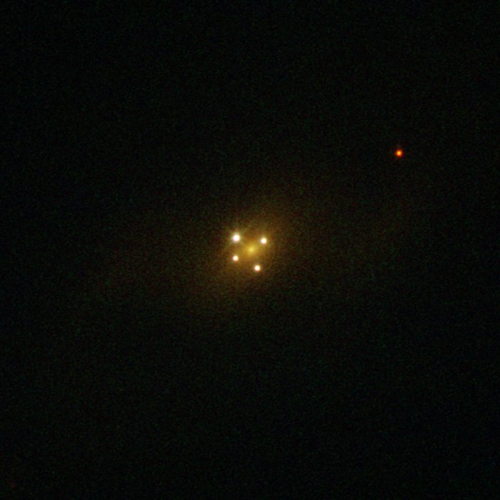

In [254]:
# SAMPLE IMAGE
from PIL import Image  # Library for image manipulation

path = df["PATH"][0] # We get the path of the image
print(path)

mainpath = "DATASET/"
print("Main path:", mainpath)
print(os.listdir(mainpath))


imagen = Image.open(path + ".jpg") # We get the image.jpg

# Define las nuevas dimensiones
nuevo_ancho = 500
nuevo_alto = 500

# Redimensiona la imagen
imagen_redimensionada = imagen.resize((nuevo_ancho, nuevo_alto))

# Muestra la imagen redimensionada en Jupyter
display(imagen_redimensionada)


In [257]:
df2['TYPE'].value_counts(normalize=True)

TYPE
GALAXY     0.311526
NEBULA     0.289720
CLUSTER    0.204569
LENSE      0.194185
Name: proportion, dtype: float64

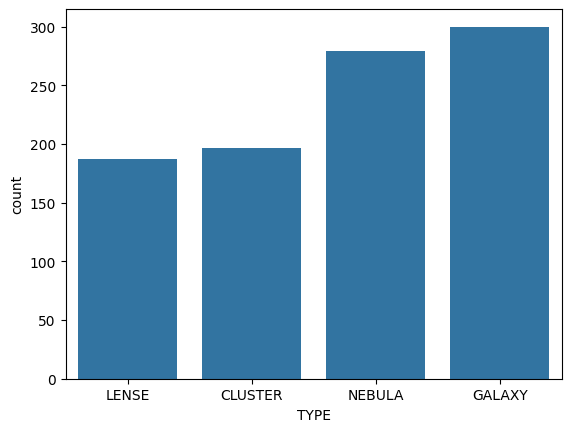

In [258]:
sns.countplot(x=df2['TYPE'])
plt.show()

In [262]:
pathimgs = df2["PATH"]
nuevo_ancho = 100  # weight
nuevo_alto = 100   # height
imgs = [
    np.array(Image.open(pathimg + ".jpg").resize((nuevo_ancho, nuevo_alto)))
    for pathimg in pathimgs
]

flatimgs = [img.flatten() for img in imgs] # we get the images in one dimension

# imgs
X = np.array(flatimgs)

y = df2["TYPE"] # labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=SEED, stratify=y)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_1528\2148469868.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [263]:
print(len(X_train), ", " , len(X_test))

674 ,  289


In [265]:
X_train_resized = np.array([resize(imagen, (nuevo_ancho, nuevo_alto)) for imagen in X_train])
X_test_resized = np.array([resize(imagen, (nuevo_ancho, nuevo_alto)) for imagen in X_test])

#  NEW FLATENING 
X_train_flat = X_train_resized.reshape((X_train_resized.shape[0], -1))
X_test_flat = X_test_resized.reshape((X_test_resized.shape[0], -1))

In [266]:
print(len(X_train_flat))
print(len(X_train_flat[5]))

674
10000


In [267]:
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier



start_time = time.time()  # Start of the runtime 
print(f"Starting training: {start_time}")

# Crea y ajusta el modelo RandomForestClassifier
rf_model = RandomForestClassifier(
    criterion='entropy',
    max_features=None,
    n_estimators=20,
    verbose=2,
    random_state=SEED
)
rf_model.fit(X_train_flat, y_train)
    
end_time = time.time()  # Get runtime in seconds
print(f"End of training: {end_time}")
elapsed_time = end_time - start_time  #Calculate the time difference
print("Training time: ",elapsed_time/60, "minutes")

Starting training: 1705314491.1940067
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
End of training: 1705314599.7101831
Training time:  1.8086029410362243 minutes


In [268]:
predicted = rf_model.predict(X_test_flat)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

     CLUSTER       0.71      0.69      0.70        59
      GALAXY       0.97      0.92      0.94        90
       LENSE       0.73      0.84      0.78        56
      NEBULA       0.86      0.83      0.85        84

    accuracy                           0.83       289
   macro avg       0.82      0.82      0.82       289
weighted avg       0.84      0.83      0.84       289



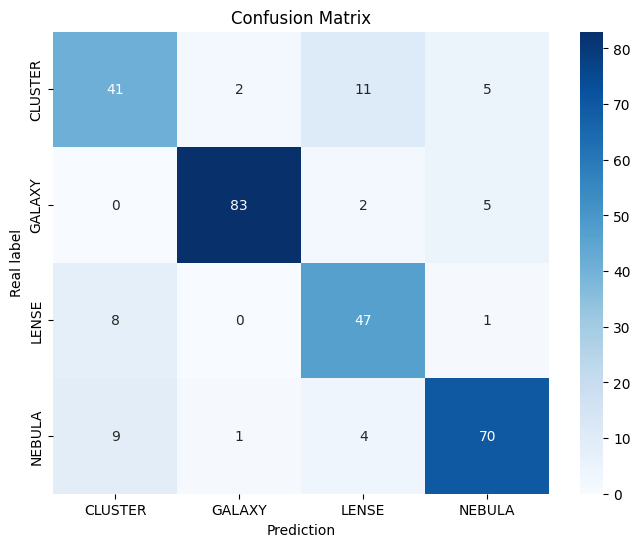

In [269]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# We get the data for the array from our test labels and the predicted data
conf_matrix = confusion_matrix(y_test, predicted)

# HEATMAP WITH THE REAL AND PREDICT DATA
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['CLUSTER', 'GALAXY', 'LENSE', 'NEBULA'],
            yticklabels=['CLUSTER', 'GALAXY', 'LENSE', 'NEBULA'])
plt.xlabel('Prediction')
plt.ylabel('Real label')
plt.title('Confusion Matrix')
plt.show()
